13368
NN_20160528_173258_2C4122206A5FC43
['NN_20160528_173258_2C4122206A5FC43.jpg', 'imageData.json']
POLYGON ((-122.344115655709 40.6305368001241, -122.337160649397 40.6304968469464, -122.337207817906 40.6269545615879, -122.344170038927 40.6270026600167, -122.344115655709 40.6305368001241))
87


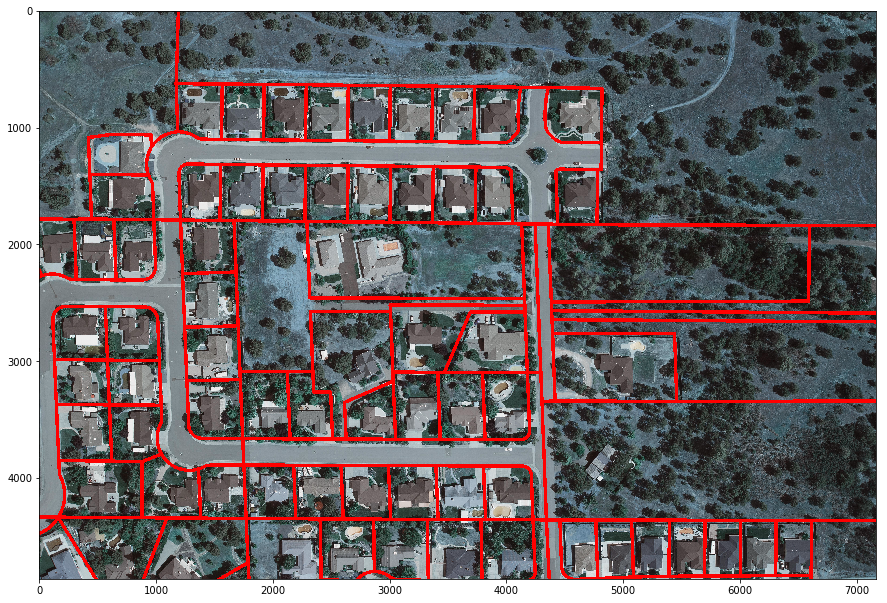

In [33]:
import numpy as np
import zipfile
from io import BytesIO
import cv2
import codecs
import json
from matplotlib import pyplot as plt
import tensorflow as tf
import pydensecrf.densecrf as dcrf
from pydensecrf.utils import compute_unary, create_pairwise_bilateral, create_pairwise_gaussian, unary_from_softmax

data_folder = 'data/geomni_parcels/redding_ca_parcels_dataset/'

def load_image_list(image_list_filename):
    """Open the image list plain text file and extract the image ids into a list"""
    with open(image_list_filename, 'r') as img_file:
        return img_file.read().splitlines()
    
def load_image(image_name):
    """Given an image name we open the zip file and extract the jpg and image metadata json"""
    images_folder = data_folder+'dataset/images'
    filename_image = '{}/{}.zip'.format(images_folder, image_name)
    # open zipfile
    with zipfile.ZipFile(filename_image, mode='r', compression=zipfile.ZIP_DEFLATED) as zf:
        print(zf.namelist()) # check that both the image and metadata are in zip file
        img_io = BytesIO(zf.read('{}.jpg'.format(image_name)))
        img_io.seek(0)
        # Construct a numpy array from the stream
        data = np.fromstring(img_io.getvalue(), dtype=np.uint8)
        # "Decode" the image from the array, preserving color
        image = cv2.imdecode(data, 1)
        
        meta_io = zf.read('imageData.json').decode('utf-8-sig')
        
        img_meta = json.loads(meta_io)
        
        return image, img_meta



img_list = load_image_list(data_folder+'amf_list.txt')
print(len(img_list))
    
example_index = img_list.index('NN_20160528_173258_2C4122206A5FC43')
print(img_list[example_index])

img, img_meta = load_image(img_list[example_index])

## load the parcels
import fiona
from fiona import crs
import pyproj as proj
from shapely.geometry import shape
from shapely.ops import transform
from functools import partial
from shapely import wkt

def load_parcels(shape_filename):
    """Open the shapefile with fiona. Iterate over all features and extract their geometry into a list"""
    all_parcels = []
    with fiona.open(shape_filename, 'r') as shasta_source:
        for index, feature in enumerate(shasta_source):
            feature_geom = shape(feature['geometry'])
            all_parcels.append(feature_geom)
    return all_parcels

all_parcels = load_parcels(data_folder+'/redding_parcels/Redding-CA-Parcels.shp')

image_bounds = wkt.loads(img_meta['bbox_wkt_latlon'])
print(image_bounds.wkt)

def get_contained_parcels(all_parcels, img_bounds):
    contained_parcels = []
    for parcel in all_parcels:
        if img_bounds.intersects(parcel):
            contained_parcels.append(parcel)
    return contained_parcels

contained_parcels = get_contained_parcels(all_parcels, image_bounds)

print(len(contained_parcels))


from math import sin
from math import cos
import numpy as np
import re

class ImageMetadata:
    """Class to handle image metadata and world-pixel/pixel-world transformations"""
    def __init__(self, image_data):
        """Initialize class with image_data - expected to be dictionary with image metadata"""
        self.image_data = image_data

        self.id = image_data['image_id']
        self.omega = image_data['omega']
        self.phi = image_data['phi']
        self.kappa = image_data['kappa']

        self.orientation = image_data['orientation']
        self.camera = [image_data['camera_pos_x'], image_data['camera_pos_y'], image_data['camera_z']]

        focal_length = image_data['focal_length']
        pp0_x = image_data['pp0_x']
        pp0_y = image_data['pp0_y']
        k0 = image_data['k0']
        k1 = image_data['k1']
        k2 = image_data['k2']
        k3 = image_data['k3']
        p1 = image_data['p1']
        p2 = image_data['p2']
        b1 = image_data['b1']
        b2 = image_data['b2']
        lens_information = {'focal_length': focal_length, 'pp0_x': pp0_x, 'pp0_y': pp0_y,
                            'k0': k0, 'k1': k1, 'k2': k2, 'k3': k3,
                            'p1': p1, 'p2': p2,
                            'b1': b1, 'b2': b2
                            }
        self.lens_information = lens_information

        self.width = int(image_data['raster_size_width'])
        self.height = int(image_data['raster_size_height'])
        self.pixel_size = image_data['pixel_size']
        self.utm_zone = image_data['utm_zone']
        self.ground_z = image_data['ground_z']

        self.DISTORTION_THRESHOLD = 0.5

        self.ext = np.array(self._calc_exterior_orientation_matrix())
        self.ext = self.ext.reshape((3, 3))

    def get_zone_int(self):
        """Get the UTM zone as integer"""
        m = re.match('(\\d+)(N|S)',self.utm_zone)
        zone_int = int(m.group(1))
        hemi = m.group(2)
        if hemi.lower() == 's':
            zone_int *= -1
        return zone_int

    def _calc_exterior_orientation_matrix(self):
        """Calculate the exterior orientation matrix given omega, phi, kappa"""
        sin_omega = sin(self.omega)
        sin_phi = sin(self.phi)
        sin_kap = sin(self.kappa)
        cos_omega = cos(self.omega)
        cos_phi = cos(self.phi)
        cos_kap = cos(self.kappa)

        ext = [
                cos_phi * cos_kap,
                cos_omega * sin_kap + sin_omega * sin_phi * cos_kap,
                sin_omega * sin_kap - cos_omega * sin_phi * cos_kap,

                -cos_phi * sin_kap,
                cos_omega * cos_kap - sin_omega * sin_phi * sin_kap,
                sin_omega * cos_kap + cos_omega * sin_phi * sin_kap,

                sin_phi,
                -sin_omega * cos_phi,
                cos_omega * cos_phi
        ]
        return ext

    def transform_world_to_pixel(self, coord):
        """Transform a world pixel(UTM coordinate system) to pixel space"""
        if self.orientation == 'V':
            raise ValueError("Orientation should be in (N,NN,S,NS,E,NE,W,NW), not V")

        dx = coord[0] - self.camera[0]
        dy = coord[1] - self.camera[1]
        dz = coord[2] - self.camera[2]
        dw = np.array([dx,dy,dz])
        ext = self.ext
        v = np.dot(ext,dw)
        photox = -self.lens_information['focal_length'] * v[0]/v[2]
        photoy = -self.lens_information['focal_length'] * v[1]/v[2]
        pixel = self.transform_photo_coord_to_pixel(photox, photoy)
        return pixel

    @staticmethod
    def line_plane_intersect(plane_point, plane_normal, line_vector):
        """Line plane intersect used to transform from pixel to world give a plane"""
        v = line_vector/np.linalg.norm(line_vector)
        den = np.dot(v, plane_normal)
        if den == 0:
            return None
        num = np.dot(plane_point,plane_normal)
        factor = num/den
        return factor*v

    def transform_pixel_to_world_given_plane(self, pixel, plane_normal, plane_point):
        """Transform a pixel space coordinate to world given 
            a plane(defined by a normal and point in UTM coordinate system)"""
        if self.orientation == 'V':
            print('orientation cannot be V: {}'.format(self.orientation))
            return None
        camera = np.array(self.camera)
        photo_coord = self.transform_pixel_to_photo_coord(pixel)
        ext = self.ext.transpose(1,0)
        line_vector = np.dot(ext, photo_coord)
        p0 = plane_point - camera
        adjPlane = (p0, plane_normal)
        intersect = self.line_plane_intersect(adjPlane[0], adjPlane[1],line_vector)
        if intersect is None:
            return None
        else:
            world = intersect + camera
            return world

    def transform_pixel_to_photo_coord(self, pixel):
        """Pixel to photo coordinate calculation"""
        x2 = float(pixel[0])/self.width - 0.5
        y2 = 0.5 - float(pixel[1])/self.height
        x1 = x2*self.get_frame_width_mm() - self.lens_information['pp0_x']
        y1 = y2*self.get_frame_height_mm() - self.lens_information['pp0_y']

        x0 = x1
        y0 = y1

        rrSq = x0*x0 + y0*y0
        dr = self.lens_information['k0'] + \
            self.lens_information['k1']*rrSq + \
            self.lens_information['k2']*rrSq*rrSq + \
            self.lens_information['k3']*rrSq*rrSq*rrSq

        photox = x0*(1 + dr) + self.lens_information['p1']*(rrSq + 2*x0*x0) + 2*self.lens_information['p2']*x0*y0 +\
            self.lens_information['b1']*x0 + self.lens_information['b2']*y0

        photoy = y0*(1 + dr) + self.lens_information['p2']*(rrSq + 2*y0*y0) + 2*self.lens_information['p1']*x0*y0
        return [photox, photoy, -self.lens_information['focal_length']]


    def get_frame_width_mm(self):
        return self.width * self.pixel_size

    def get_frame_height_mm(self):
        return self.height * self.pixel_size

    def transform_photo_coord_to_pixel(self, photo_x, photo_y):
        """Photo coord to pixel calculation"""
        frame_height = self.get_frame_height_mm()
        frame_width = self.get_frame_width_mm()
        x0 = photo_x
        y0 = photo_y

        limit = self.DISTORTION_THRESHOLD + 0.5
        min_limit_x = -limit * frame_width - self.lens_information['pp0_x']
        max_limit_x = limit * frame_width - self.lens_information['pp0_x']

        min_limit_y = -limit * frame_height - self.lens_information['pp0_y']
        max_limit_y = limit * frame_height - self.lens_information['pp0_y']

        photo_coord_in_image = min_limit_x <= x0 <= max_limit_x and min_limit_y <= y0 <= max_limit_y
        if photo_coord_in_image:
            # apply distortion
            photo_x_sqr = photo_x * photo_x
            photo_y_sqr = photo_y * photo_y

            photox3 = photo_x - self.lens_information['b1'] * photo_x - self.lens_information['b2'] * photo_y
            photoy3 = photo_y

            photox2 = photox3 - 2 * self.lens_information['p2'] * photo_x * photo_y
            photoy2 = photoy3 - 2 * self.lens_information['p1'] * photo_x * photo_y
            for i in range(4):
                rrSq = x0 * x0 + y0 * y0
                rrSq2 = rrSq * rrSq
                rrSq3 = rrSq2 * rrSq

                dr = self.lens_information['k0'] + \
                    self.lens_information['k1'] * rrSq + \
                    self.lens_information['k2'] * rrSq2 + \
                    self.lens_information['k3'] * rrSq3

                photox1 = photox2 - self.lens_information['p1'] * (rrSq + 2*photo_x_sqr)
                photoy1 = photoy2 - self.lens_information['p2'] * (rrSq + 2*photo_y_sqr)

                x0 = photox1 / (1 + dr)
                y0 = photoy1 / (1 + dr)

        x1 = x0
        y1 = y0
        x2 = (x1 + self.lens_information['pp0_x'])/frame_width
        y2 = (y1 + self.lens_information['pp0_y'])/frame_height

        px = float(self.width) * (0.5 + x2)
        py = float(self.height) * (0.5 - y2)
        return [px,py]

img_meta_obj = ImageMetadata(img_meta)

def wkt_to_utm_polygon(parcel_wkt_lat_long, img_meta):
    """Function to transform from wkt polygon in lat/long
    into a shapely polygon in utm coordinate system"""
    parcel_geom = wkt.loads(parcel_wkt_lat_long)
    lat_lon_proj = proj.Proj(init='epsg:4326')
    utm_proj = proj.Proj(proj='utm', zone=img_meta.utm_zone)
    project = partial(proj.transform, lat_lon_proj, utm_proj)
    return transform(project, parcel_geom)

parcel_utm_polygon = wkt_to_utm_polygon(contained_parcels[0].wkt, img_meta_obj)

def draw_utm_poly(img_region, img_meta, np_offset, utm_polygon, color=(255,0,0), thick=2):
    """Input image and image metadata as well as a utm polygon and the polygon will be drawn on the
    image with the given color and line thickness"""
    polys =  []
    if utm_polygon.type == 'MultiPolygon':
        for geom in utm_polygon:
            polys.append(geom)
    elif utm_polygon.type == 'Polygon':
        polys.append(utm_polygon)
    for poly in polys:
        pixel_parcel_geom = []
        for coord in poly.exterior.coords:
            coord = np.array([coord[0], coord[1], img_meta.ground_z]) #coord requires z value
            pixel = img_meta.transform_world_to_pixel(coord)
            pixel = pixel - np_offset
            pixel_parcel_geom.append(pixel)            
        pixel_parcel_geom = np.array(pixel_parcel_geom, dtype=np.int32)
        pixel_parcel_geom = pixel_parcel_geom.reshape((-1,1,2))
        cv2.polylines(img_region,[pixel_parcel_geom],True,color, thickness=thick)

img_overlay = np.copy(img)
for parcel in contained_parcels:
    utm_poly = wkt_to_utm_polygon(parcel.wkt, img_meta_obj)
    draw_utm_poly(img_overlay, img_meta_obj, np.array([0,0]), utm_poly, thick=28)

plt.figure(figsize=(15, 15))    
plt.imshow(img_overlay)
plt.show()

(1000, 1000, 3)


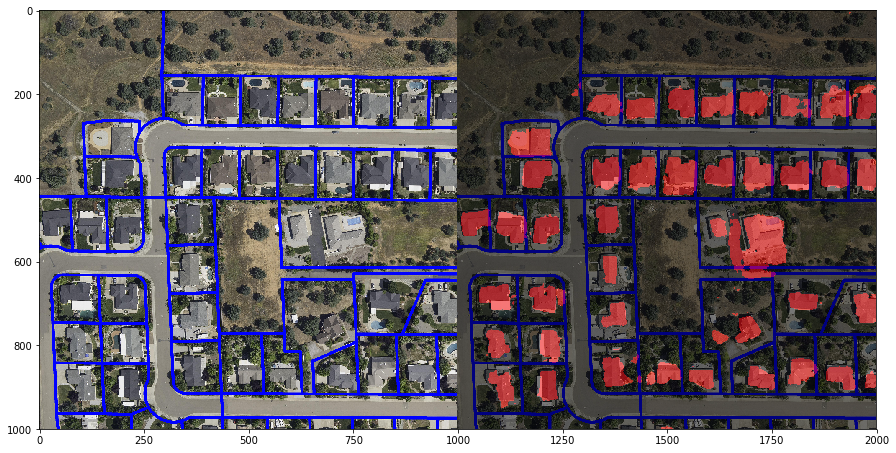

In [46]:

## for the moment, let us crop and resize the image
img = img[:4000, :4000, :]
img = cv2.resize(img, (1000,1000), interpolation=cv2.INTER_CUBIC)
print(img.shape)

# logs folder and model file
logs_dir = 'logs/'
meta_file = logs_dir+'model.cpkt-49999.meta'

sess = tf.Session()

saver = tf.train.import_meta_graph(meta_file)
saver.restore(sess,tf.train.latest_checkpoint(logs_dir))

graph = tf.get_default_graph()
image_place = graph.get_tensor_by_name("input_image:0")
label_place = graph.get_tensor_by_name("label:0")
keep_probability = graph.get_tensor_by_name("keep_probabilty:0")


#pred_annotation = graph.get_tensor_by_name("prediction:0")

prediction = graph.get_tensor_by_name("prediction:0")
final_layer = graph.get_tensor_by_name("Final_layer:0")
probabilities = tf.nn.softmax(final_layer)

input_image = np.array(img, np.float32)
#gt_image = cv2.imread(gt_name,0)[0+x_offset:1000+x_offset, 0+y_offset:1000+y_offset]

tensor_image = np.expand_dims(input_image, 0)

preds, probs = sess.run([prediction, probabilities], feed_dict={image_place: tensor_image, keep_probability: 1.0})

softmax = probs.squeeze()
softmax = softmax.transpose((2,0,1))

## get the nagative log likelihood for the softmax
unary = unary_from_softmax(softmax)
unary = np.ascontiguousarray(unary)

CRF = dcrf.DenseCRF(input_image.shape[0] * input_image.shape[1], 2)

CRF.setUnaryEnergy(unary)

# This potential penalizes small pieces of segmentation that are
# spatially isolated -- enforces more spatially consistent segmentations
feats = create_pairwise_gaussian(sdims=(10, 10), shape=input_image.shape[:2])
CRF.addPairwiseEnergy(feats, compat=3, kernel=dcrf.DIAG_KERNEL, normalization=dcrf.NORMALIZE_SYMMETRIC)

# This creates the color-dependent features --
# because the segmentation that we get from CNN are too coarse
# and we can use local color features to refine them
feats = create_pairwise_bilateral(sdims=(50, 50), schan=(20, 20, 20),
                                   img=input_image, chdim=2)

CRF.addPairwiseEnergy(feats, compat=10,
                     kernel=dcrf.DIAG_KERNEL,
                     normalization=dcrf.NORMALIZE_SYMMETRIC)
Q = CRF.inference(5)
res = np.argmax(Q, axis=0).reshape((input_image.shape[0], input_image.shape[1]))

color_coded_res = np.zeros(shape=(1000,1000,3), dtype=np.uint8)
color_coded_res[res==1] = [255,0,0]

unary_out = preds.squeeze()
color_coded_unary_out = np.zeros(shape=(1000,1000,3), dtype=np.uint8)
color_coded_unary_out[unary_out==1]=[255,0,0]


overlaid_res = np.uint8(input_image/2.0 + color_coded_unary_out/2.0)

grand_out = np.concatenate([np.uint8(input_image)[:,:,::-1], overlaid_res], axis=1)

#plt.figure(figsize=(15, 15))
#plt.imshow(grand_out)
plt.figure(figsize=(15, 30))
img_parcel = img_overlay[:4000, :4000, :][:,:,::-1]
img_parcel = cv2.resize(img_parcel, (1000,1000), interpolation=cv2.INTER_CUBIC)
overlaid_res_parcel =  np.uint8(img_parcel/2.0 + color_coded_unary_out/2.0)
grand_out_parcel = np.concatenate([np.uint8(img_parcel), overlaid_res_parcel], axis=1)
plt.imshow(grand_out_parcel)
plt.show()